In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import h5py
from astropy.io import fits
from astropy.convolution import Gaussian1DKernel, convolve
from scipy import interpolate
import pickle
import random
from scipy.interpolate import interp1d

In [2]:
# Directory path where your files are located
directory_path_h = '../data/ASKAP_spectra/Hydra'
directory_path_n= '../data/ASKAP_spectra/Norma'

# Common part of the filename
common_part = '_askap_spectrum.txt'

# List all files in the Hydra directory that contain the common part
all_files_h = [f for f in os.listdir(directory_path_h) if common_part in f]

# List all files in the Norma directory that contain the common part
all_files_n = [k for k in os.listdir(directory_path_n) if common_part in k]


In [ ]:
len(all_files_h)

In [ ]:
len(all_files_n)

### Test

In [ ]:
all_files_h[0]

In [ ]:
all_files_n[0]

In [ ]:
data = np.loadtxt(f'{directory_path_n}/{all_files_n[4]}', skiprows=1)

In [ ]:
velocity = data[:, 1]
amplitude = data[:, 2]

#Measue variability
rms_spect = np.sqrt(np.mean(amplitude**2))

#Mask signal channels
spectrum = np.copy(amplitude)
spectrum[spectrum < rms_spect - (np.max(spectrum)-rms_spect) ] = rms_spect

#Normalization
y = spectrum
x = velocity
pars = np.polyfit(x, y, 1)
p = np.poly1d(pars)
tauhi = np.array(amplitude/p(x))

# Tau
tau = np.log(tauhi)*(-1)
rms = np.std(tau)
#Smoothing
g = Gaussian1DKernel(1)
tau_smooth = convolve(tau, g, boundary='extend')
rms_smooth = np.std(tau_smooth)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [2, 1]})

# Plot signals on ax1
ax1.plot(x, tau, ':', linewidth=1, color='b', label='Signal')
ax1.plot(x, tau_smooth, '-', linewidth=1, color='r', label='Smoothed')
ax1.axhspan(-3*rms_smooth, 3*rms_smooth, alpha=0.2, color='g')
ax1.axhline(0, color='k', linestyle='--', linewidth=2)
#ax1.axhline(rms_smooth * 3, color='k', linestyle='--', linewidth=1)
ax1.set_ylabel(r'${\tau}$', fontsize=15)
ax1.grid(True)
ax1.legend()

# Plot on ax2
ax2.plot(x, tauhi, color='g')
ax2.axhspan(1 - 3*np.std(tauhi), 1 + 3*np.std(tauhi), alpha=0.2, color='grey')
ax2.axhline(1, color='k', linestyle='--', linewidth=2)

# Identify points where tauhi is below the threshold
below_threshold = tauhi < (1 - 3 * np.std(tauhi))
ax2.plot(x[below_threshold], tauhi[below_threshold], 'ro')  # Mark points in red

# Set labels
ax2.set_xlabel('v [Km/s]', fontsize=15)
ax2.set_ylabel(r'$e^{-\tau}$', fontsize=15)

# Show the plot
plt.show()



### Ploting

In [ ]:
def plot_spectra(files_spectra,directory_path, gkernel, image_name=None):
    # Calculate the number of rows and columns for subplots
    num_files = len(files_spectra)
    num_rows = int(np.ceil(num_files / 3))  # 3 subplots per row

    # Create a single figure with multiple subplots
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, 8*num_rows))
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

    # Iterate through matching files and create subplots for each file
    for i, file_name in enumerate(files_spectra):
        # Construct the full file path
        file_path = os.path.join(directory_path, file_name)

        # Read data from the text file into a NumPy array, skipping the header row
        data = np.loadtxt(file_path, skiprows=1)

        # Extract velocity and amplitude columns
        velocity = data[:, 1]
        amplitude = data[:, 2]
        
        # Measure variability
        rms_spect = np.sqrt(np.mean(amplitude**2))
        
        # Mask signal channels
        spectrum = np.copy(amplitude)
        spectrum[spectrum < rms_spect - (np.max(spectrum) - rms_spect)] = rms_spect
        
        # Normalization
        y = spectrum
        x = velocity
        pars = np.polyfit(x, y, 1)
        p = np.poly1d(pars)
        tauhi = np.array(amplitude / p(x))
        
        # Tau
        tau = np.log(tauhi) * (-1)
        rms = np.std(tau)
        
        # Smoothing
        g = Gaussian1DKernel(gkernel)
        tau_smooth = convolve(tau, g, boundary='extend')
        rms_smooth = np.std(tau_smooth)

        # Create a nested grid within each subplot
        outer_ax = axes[i]
        gs = outer_ax.get_gridspec()
        outer_ax.remove()

        inner_gs = gs[i].subgridspec(2, 1, height_ratios=[3, 1])
        ax1 = fig.add_subplot(inner_gs[0])
        ax2 = fig.add_subplot(inner_gs[1])

        # Plotting the first panel
        ax1.plot(x, tau, linestyle=':', linewidth=1, color='b', alpha = 0.6, label='Signal')
        ax1.plot(x, tau_smooth, linestyle='-', linewidth=1, color='r', label=f'Gaussian kernel {gkernel}')
        ax1.axhspan(-3*rms_smooth, 3*rms_smooth, alpha=0.2, color='g')
        ax1.axhline(0, color='k', linestyle='--', linewidth=2)
        ax1.set_ylabel(r'${\tau}$', fontsize=15)
        ax1.grid(True)
        ax1.legend()
        ax1.set_title(f'File: {file_name}')

        # Plotting the second panel
        ax2.plot(x, tauhi, color='g')
        ax2.axhspan(1 - 3*np.std(tauhi), 1 + 3*np.std(tauhi), alpha=0.2, color='grey')
        ax2.axhline(1, color='k', linestyle='--', linewidth=2)
        ax2.set_xlabel('v[Km/s]', fontsize=15)
        ax2.set_ylabel(r'$e^{-\tau}$')

        # Title for the overall plot area
        #outer_ax.set_title(f'File: {file_name}')

    # Hide any remaining empty subplots, if any
    for j in range(num_files, num_rows * 3):
        fig.delaxes(axes[j])

    # Adjust layout and display the figure
    plt.tight_layout()
    if image_name is not None:
        # Ensure the output directory exists
        output_dir = os.path.join('../images', 'ASKAP')  # Change Norma or Hydra
        os.makedirs(output_dir, exist_ok=True)

        # Save the figure
        output_path = os.path.join(output_dir, f'{image_name}.pdf')
        plt.savefig(output_path, format='pdf')

    plt.show()


In [ ]:
random_samples_n = random.sample(all_files_n, 30)
plot_spectra(random_samples_n, directory_path_n, 1, 'spectra_norma_g1')

In [ ]:
random_samples_h = random.sample(all_files_h, 30)
plot_spectra(random_samples_h, directory_path_h, 1, 'spectra_hydra_g1')
#plot_spectra(files_spectra_v2,2, 'spectra_v2_g2',source_name)

## Arrays

In [3]:
a, b = 6, 9
spect_h = np.zeros((270, a, b))            #Resolution of 4 km/s 
spect_h_smooth = np.zeros((270, a, b))     #Resolution of 4 km/s Smoothed
files_h = {}                        #Dictionary for source's name

In [4]:
c, d = 17, 18
spect_n = np.zeros((270, c, d))            #Resolution of 4 km/s 
spect_n_smooth = np.zeros((270, c, d))     #Resolution of 4 km/s Smoothed
files_n = {}      

### Hydra

In [5]:
gkernel = 1

for i, file_name in enumerate(all_files_h):
    # Construct the full file path
    file_path = os.path.join(directory_path_h, file_name)
    
    # Read data from the text file into a NumPy array, skipping the header row
    data = np.loadtxt(file_path, skiprows=1)

    # Extract velocity and amplitude columns
    velocity = data[:, 1]
    amplitude = data[:, 2]
    
    #Measue variability
    rms_spect = np.sqrt(np.mean(amplitude**2))
    
    #Mask signal channels
    spectrum = np.copy(amplitude)
    spectrum[spectrum < rms_spect - (np.max(spectrum)-rms_spect) ] = rms_spect
    
    #Normalization
    y = spectrum
    x = velocity
    pars = np.polyfit(x, y, 1)
    p = np.poly1d(pars)
    tauhi = np.array(amplitude/p(x))
    
    # Tau
    tau = np.log(tauhi)*(-1)
    if np.isnan(tau).any():
        # Get indices of valid and invalid (NaN) values
        valid_idx = np.where(~np.isnan(tau))[0]
        invalid_idx = np.where(np.isnan(tau))[0]
        
        # Interpolate only over the valid points
        interpolator = interp1d(x[valid_idx], tau[valid_idx], kind='linear', fill_value='extrapolate')
        
        # Apply interpolation to the NaN values
        tau[invalid_idx] = interpolator(x[invalid_idx])
      
    rms = np.std(tau)
    #Smoothing
    g = Gaussian1DKernel(gkernel)
    tau_smooth = convolve(tau, g, boundary='extend')

    if i == 0:
        crval3_h = velocity[-1]
    
    # Calculate indices for atca_spect_v2
    index1 = i // b  # Row index
    index2 = i % b   # Column index
    
    # Assign tauhi values to atca_spect_v2 at specified indices
    #we reversed the array since we took the initial velocity form the end of the file
    tau_reversed_h = tau[::-1]
    spect_h[:,index1, index2] = tau_reversed_h
    tau_smooth_reversed_h = tau_smooth[::-1]
    spect_h_smooth[:, index1, index2] = tau_smooth_reversed_h

    # Fits transpose the axis
    files_h[file_name.split('_askap_spectrum.txt')[0]] = {"pos":(index2, index1), "vel": velocity[-1]} 

### Norma

In [6]:

for i, file_name in enumerate(all_files_n):
    # Construct the full file path
    file_path = os.path.join(directory_path_n, file_name)
    
    # Read data from the text file into a NumPy array, skipping the header row
    data = np.loadtxt(file_path, skiprows=1)

    # Extract velocity and amplitude columns
    velocity = data[:, 1]
    amplitude = data[:, 2]
    
    #Measue variability
    rms_spect = np.sqrt(np.mean(amplitude**2))
    
    #Mask signal channels
    spectrum = np.copy(amplitude)
    spectrum[spectrum < rms_spect - (np.max(spectrum)-rms_spect) ] = rms_spect
    
    #Normalization
    y = spectrum
    x = velocity
    pars = np.polyfit(x, y, 1)
    p = np.poly1d(pars)
    tauhi = np.array(amplitude/p(x))
    
    # Tau
    tau = np.log(tauhi)*(-1)
    if np.isnan(tau).any():
        # Get indices of valid and invalid (NaN) values
        valid_idx = np.where(~np.isnan(tau))[0]
        invalid_idx = np.where(np.isnan(tau))[0]
        
        # Interpolate only over the valid points
        interpolator = interp1d(x[valid_idx], tau[valid_idx], kind='linear', fill_value='extrapolate')
        
        # Apply interpolation to the NaN values
        tau[invalid_idx] = interpolator(x[invalid_idx])
      
    rms = np.std(tau)
    #Smoothing
    g = Gaussian1DKernel(gkernel)
    tau_smooth = convolve(tau, g, boundary='extend')

    if i == 0:
        crval3_n = velocity[-1]
    
    # Calculate indices for atca_spect_v2
    index1 = i // d  # Row index
    index2 = i % d   # Column index
    
    tau_reversed_n = tau[::-1]
    spect_n[:,index1, index2] = tau_reversed_n
    tau_smooth_reversed_n = tau_smooth[::-1]
    spect_n_smooth[:, index1, index2] = tau_smooth_reversed_n


    # Fits transpose the axis
    files_n[file_name.split('_askap_spectrum.txt')[0]] = {"pos":(index2, index1),  "vel": velocity[-1]} 

/tmp/ipykernel_3902/1362549844.py:27: RuntimeWarning: invalid value encountered in log
  tau = np.log(tauhi)*(-1)


### Creation of FITS file

In [7]:
print("ASKAP cube for Norma field: ", spect_n_smooth.shape)
print("ASKAP cube for Hydra field ", spect_h_smooth.shape)

ASKAP cube for Norma field:  (270, 17, 18)
ASKAP cube for Hydra field  (270, 6, 9)


In [8]:
print(crval3_h,
      crval3_n)

-446.17191362022163 -437.311662453059


In [9]:
def fits_cube(data_cube, CDELT3, CRVAL3, name, source):
    # Create a new FITS HDU object from the NumPy 
    hdu = fits.PrimaryHDU(data_cube)

    hdu.header['NAXIS'] = 3
    hdu.header['NAXIS1'] = data_cube.shape[1]
    hdu.header['NAXIS2'] = data_cube.shape[2]
    hdu.header['NAXIS3'] = data_cube.shape[0]


    hdu.header['CRPIX1'] = 1.0e+00
    hdu.header['CDELT1'] = 1.0e+00
    hdu.header['CRVAL1'] = 1.0e+00
    hdu.header['CTYPE1']  = 'RA---NCP'
    hdu.header['CUNIT1'] = 'deg'

    hdu.header['CRPIX2'] = 1.0e+00
    hdu.header['CDELT2'] = 1.0e+00
    hdu.header['CRVAL2'] = 1.0e+00
    hdu.header['CTYPE2']  = 'DEC--NCP'
    hdu.header['CUNIT2'] = 'deg'


    hdu.header['CRPIX3']  = 1.0e+00
    hdu.header['CDELT3'] = CDELT3      #km/s
    hdu.header['CTYPE3']  = 'VELO-LSR'
    hdu.header['CRVAL3'] = CRVAL3      #km/s
    hdu.header['CUNIT3'] = 'km/s' 
    
    hdu.header['DATAMIN'] =  np.nanmin(data_cube)                        
    hdu.header['DATAMAX'] =  np.nanmax(data_cube)   
    
    hdu.header['SPECSYS'] = 'LSRK' 
    hdu.header['BUNIT'] = 'JY/BEAM '                                                                                                                                                                                                                                                                                                          


    # Save the FITS file
    hdu.writeto(f'../data_cubes/{source}/{name}.fits', overwrite=True)


In [10]:
fits_cube(spect_n,  3.908539639005994 , crval3_n, 'spectra_norma_raw', 'ASKAP')
fits_cube(spect_h, 3.908539639005994 , crval3_h, 'spectra_hydra_raw', 'ASKAP')

In [11]:

with open('../data_cubes/ASKAP/coordinates_hydra.pkl', 'wb') as f:
    pickle.dump(files_h, f)

with open('../data_cubes/ASKAP/coordinates_norma.pkl', 'wb') as f:
    pickle.dump(files_n, f)


## Checking

In [12]:
from spectral_cube import SpectralCube

# Path to the FITS file
file_path1 = '../data_cubes/ASKAP/spectra_norma_raw.fits'
file_path2 = '../data_cubes/ASKAP/spectra_hydra_raw.fits'


cube1 = SpectralCube.read(file_path1)
cube2 = SpectralCube.read(file_path2)
# Open the FITS file
with fits.open(file_path1) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Access the primary HDU (Header/Data Unit)
    primary_hdu1 = hdul[0]
    
    # Print the header of the primary HDU
    print(primary_hdu1.header)
    
    # Access the data in the primary HDU
    data1 = primary_hdu1.data

# Display some basic information about the data
print(f'Data shape: {data1.shape}')
print(f'Data type: {data1.dtype}')

# Open the FITS file
with fits.open(file_path2) as hdul:
    # Print the information about the FITS file
    hdul.info()
    
    # Access the primary HDU (Header/Data Unit)
    primary_hdu2 = hdul[0]
    
    # Print the header of the primary HDU
    print(primary_hdu2.header)
    
    # Access the data in the primary HDU
    data2 = primary_hdu2.data

# Display some basic information about the data
print(f'Data shape: {data2.shape}')
print(f'Data type: {data2.dtype}')


Filename: ../data_cubes/ASKAP/spectra_norma_raw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      26   (18, 17, 270)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                   18                                                  NAXIS2  =                   17                                                  NAXIS3  =                  270                                                  EXTEND  =                    T                                                  CRPIX1  =                  1.0                                                  CDELT1  =                  1.0                                                  CRVAL1  =                  1.0                                                  CTYPE1  = 'RA---

In [13]:
cube1.spectral_axis

<Quantity [-4.37311662e+02, -4.33403123e+02, -4.29494583e+02,
           -4.25586044e+02, -4.21677504e+02, -4.17768964e+02,
           -4.13860425e+02, -4.09951885e+02, -4.06043345e+02,
           -4.02134806e+02, -3.98226266e+02, -3.94317726e+02,
           -3.90409187e+02, -3.86500647e+02, -3.82592108e+02,
           -3.78683568e+02, -3.74775028e+02, -3.70866489e+02,
           -3.66957949e+02, -3.63049409e+02, -3.59140870e+02,
           -3.55232330e+02, -3.51323790e+02, -3.47415251e+02,
           -3.43506711e+02, -3.39598171e+02, -3.35689632e+02,
           -3.31781092e+02, -3.27872553e+02, -3.23964013e+02,
           -3.20055473e+02, -3.16146934e+02, -3.12238394e+02,
           -3.08329854e+02, -3.04421315e+02, -3.00512775e+02,
           -2.96604235e+02, -2.92695696e+02, -2.88787156e+02,
           -2.84878617e+02, -2.80970077e+02, -2.77061537e+02,
           -2.73152998e+02, -2.69244458e+02, -2.65335918e+02,
           -2.61427379e+02, -2.57518839e+02, -2.53610299e+02,
        

In [14]:
cube2.spectral_axis

<Quantity [-4.46171914e+02, -4.42263374e+02, -4.38354834e+02,
           -4.34446295e+02, -4.30537755e+02, -4.26629215e+02,
           -4.22720676e+02, -4.18812136e+02, -4.14903597e+02,
           -4.10995057e+02, -4.07086517e+02, -4.03177978e+02,
           -3.99269438e+02, -3.95360898e+02, -3.91452359e+02,
           -3.87543819e+02, -3.83635279e+02, -3.79726740e+02,
           -3.75818200e+02, -3.71909660e+02, -3.68001121e+02,
           -3.64092581e+02, -3.60184042e+02, -3.56275502e+02,
           -3.52366962e+02, -3.48458423e+02, -3.44549883e+02,
           -3.40641343e+02, -3.36732804e+02, -3.32824264e+02,
           -3.28915724e+02, -3.25007185e+02, -3.21098645e+02,
           -3.17190106e+02, -3.13281566e+02, -3.09373026e+02,
           -3.05464487e+02, -3.01555947e+02, -2.97647407e+02,
           -2.93738868e+02, -2.89830328e+02, -2.85921788e+02,
           -2.82013249e+02, -2.78104709e+02, -2.74196170e+02,
           -2.70287630e+02, -2.66379090e+02, -2.62470551e+02,
        

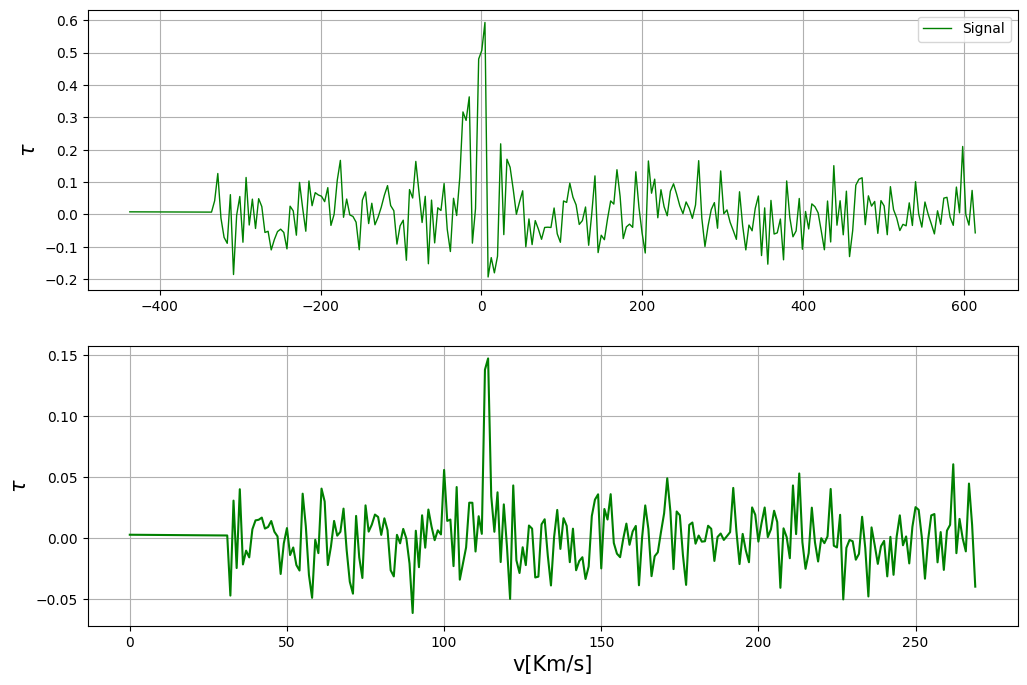

In [15]:

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1.plot(cube1.spectral_axis, data1[:,3,3], linestyle='-', linewidth=1, color='g', label='Signal')
ax1.set_ylabel(r'$\tau$', fontsize=15)
ax1.grid(True)

# Add legend
ax1.legend()

ax2.plot(data2[:,3,3], color = 'g', label ='Smoothed')
ax2.set_xlabel('v[Km/s]', fontsize=15)
ax2.set_ylabel(r'$\tau$', fontsize=15)
ax2.grid(True)

plt.show()
